<a href="https://colab.research.google.com/github/erwanBellon/Project-ML-SDM/blob/main/code/XAI_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Feature map



#### I.1 : setup

In [1]:
# @title
#Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Cloning repo or fetch latest changes and path management
%cd /content
!rm -rf Project-ML-SDM
!git clone https://github.com/erwanBellon/Project-ML-SDM.git
%cd /content/Project-ML-SDM
!git pull

import os
from pathlib import Path

# Move into the project directory
%cd /content/Project-ML-SDM/code
print("Current working directory:", Path.cwd())

# Define main project dir and outputs
PROJECT_ROOT_DIR = Path.cwd().parent
OUTPUTS_PATH = PROJECT_ROOT_DIR / "outputs"
OUTPUTS_PATH.mkdir(parents=True, exist_ok=True)
print("Outputs will be saved to:", OUTPUTS_PATH)


# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU detected. CNNs can be slow without GPU.")

# Common imports
import pandas as pd
import numpy as np
!pip install rasterio
import rasterio
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# To make notebook reproducible
np.random.seed(123)
tf.random.set_seed(123)

# For plots
import matplotlib.pyplot as plt
%matplotlib inline

# Load Tensorboard
%load_ext tensorboard

/content
Cloning into 'Project-ML-SDM'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 597 (delta 84), reused 19 (delta 19), pack-reused 450 (from 1)
Receiving objects: 100% (597/597), 20.67 MiB | 14.35 MiB/s, done.
Resolving deltas: 100% (435/435), done.
/content/Project-ML-SDM
Already up to date.
/content/Project-ML-SDM/code
Current working directory: /content/Project-ML-SDM/code
Outputs will be saved to: /content/Project-ML-SDM/outputs


In [2]:
print(Path.cwd())

/content/Project-ML-SDM/code


## I.2 Load the model using a CNN-ANN framework

In [3]:
# @title
# Path to your saved model
model_path = Path.cwd() /"../outputs/cnn_bestModel.keras"

# Load model
model = load_model(model_path)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 30, 30, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 30, 30, 1) │          0 │ image_input[0][0] │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 30, 30, 1) │          0 │ random_flip[0][0] │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation  │ (None, 30, 30, 1) │          0 │ random_zoom[0][0] │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │        832 │ random_translati… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 30, 30,    │     25,632 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │    102,528 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ table_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         48 │ table_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_output (Dense)  │ (None, 32)        │    200,736 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ table_branch_output │ (None, 8)         │        136 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40)        │          0 │ cnn_output[0][0], │
│ (Concatenate)       │                   │            │ table_branch_out… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │        264 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ suitability (Dense) │ (None, 1)         │          9 │ dense_2[0][0]   

 Total params: 994,493 (3.79 MB)

 Trainable params: 331,497 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 662,996 (2.53 MB)

### I.3 Load image data (and table input) and preprocess the datas


In [25]:
# --- Load images ---
presences_path = Path("../data/cropped_landcover/presences")
absences_path = Path("../data/cropped_landcover/absences")

def load_images_from_folder(folder):
    tif_files = list(folder.glob("*.tif"))
    images = []
    image_indices = []
    for tif in tif_files:
        with rasterio.open(tif) as src:
            img = src.read()
            img = np.transpose(img, (1,2,0))
            images.append(img.astype(np.float32))
        # Extract the line index from the filename (`crop_3000_118.tif`)
        idx = int(tif.stem.split("_")[-1])
        image_indices.append(idx)
    return np.array(images), np.array(image_indices)

images_pres, indices_pres = load_images_from_folder(presences_path)
images_abs, indices_abs = load_images_from_folder(absences_path)
print(f"Presences: {images_pres.shape}, Absences: {images_abs.shape}")

# Build dataset & labels
X = np.concatenate([images_pres, images_abs], axis=0)
y = np.concatenate([np.ones(len(images_pres)), np.zeros(len(images_abs))], axis=0).astype(np.int32)
image_indices = np.concatenate([indices_pres, indices_abs], axis=0)  # all image row indices

# --- Load table data ---
rds_path = Path("../data/Table_preds/function_3_100.rds")
!pip install pyreadr
import pyreadr
result = pyreadr.read_r(rds_path)
table_df = result[None]  # get DataFrame

# Select only the rows corresponding to actual images
table_features_all = table_df[['MAP','MAT']].astype(float)
table_features = table_features_all.iloc[image_indices].reset_index(drop=True)

# Normalize
#table_features = (table_features - table_features.min()) / (table_features.max() - table_features.min())
#table_features = table_features.to_numpy(dtype=np.float32)


X_train, X_temp, table_train, table_temp, y_train, y_temp = train_test_split(
    X, table_features, y,
    test_size=0.2,
    random_state=123,
    stratify=y
)

X_valid, X_test, table_valid, table_test, y_valid, y_test = train_test_split(
    X_temp, table_temp, y_temp,
    test_size=0.5,
    random_state=123,
    stratify=y_temp
)

# Normalize using TRAIN ONLY

min_vals = table_train.min(axis=0)
max_vals = table_train.max(axis=0)

table_train = (table_train - min_vals) / (max_vals - min_vals)
table_valid = (table_valid - min_vals) / (max_vals - min_vals)
table_test  = (table_test  - min_vals) / (max_vals - min_vals)

table_train = table_train.to_numpy(dtype=np.float32)
table_valid = table_valid.to_numpy(dtype=np.float32)
table_test  = table_test.to_numpy(dtype=np.float32)


Presences: (117, 30, 30, 1), Absences: (200, 30, 30, 1)


In [26]:
# @title
train_ds = tf.data.Dataset.from_tensor_slices(((X_train, table_train), y_train))
valid_ds = tf.data.Dataset.from_tensor_slices(((X_valid, table_valid), y_valid))
test_ds  = tf.data.Dataset.from_tensor_slices(((X_test, table_test), y_test))


# Add `.name` attribute like TFDS
train_ds.name = "Training"
valid_ds.name = "Validation"
test_ds.name  = "Test"

In [27]:
# @title
def preprocess_multi_inputs(inputs, label):
    image, table = inputs
    # Convert image to float32 and add channel dimension if needed
    image = tf.cast(image, tf.float32)
    # Replace Nan (non-forest) with 0s
    image = tf.where(tf.math.is_nan(image), 0.0, image)

    if len(image.shape) == 3:  # (H,W,C) or (H,W)
        image = tf.expand_dims(image, -1)  # ensures (H,W,1)
    # Table should already be (batch_size, 2) after batching
    table = tf.cast(table, tf.float32)
    label = tf.cast(label, tf.float32)
    return (image, table), label

In [28]:
# @title
train_ds = (
    tf.data.Dataset.from_tensor_slices(((X_train, table_train), y_train))
      .shuffle(1000, reshuffle_each_iteration=True)   # <--- SHUFFLE HERE
      .map(preprocess_multi_inputs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE)
)
valid_ds = (
    tf.data.Dataset.from_tensor_slices(((X_valid, table_valid), y_valid))
      .map(preprocess_multi_inputs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices(((X_test, table_test), y_test))
      .map(preprocess_multi_inputs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE)
)

# Add `.name` attribute like TFDS
train_ds.name = "Training"
valid_ds.name = "Validation"
test_ds.name  = "Test"


Use the test dataset and prepare 15 sample images


In [29]:
# @title
sample_images = []
sample_tables = []

for (img, tab), label in test_ds.take(20):  # to get single samples
    # Image preprocessing
    img = tf.cast(img, tf.float32)
    img = tf.where(tf.math.is_nan(img), 0.0, img)
    if len(img.shape) == 2:  # (H,W)
        img = tf.expand_dims(img, -1)  # (H,W,1)
    sample_images.append(img.numpy())

    # Table preprocessing
    tab = tf.cast(tab, tf.float32)
    sample_tables.append(tab.numpy())

# Convert to numpy arrays with batch dimension
sample_images = np.stack(sample_images)
sample_tables = np.stack(sample_tables)

print("Sample images shape:", sample_images.shape)   # (5,H,W,C)
print("Sample tables shape:", sample_tables.shape)   # (5,n_features)
print("Min/Max values:", img.numpy().min(), img.numpy().max())



Sample images shape: (20, 30, 30, 1, 1)
Sample tables shape: (20, 2)
Min/Max values: 0.0 1.0


## I.4. Looking at the feature maps

In [30]:
# @title
# Print all layers with their output shapes
for i, layer in enumerate(model.layers):
    try:
        shape = layer.output.shape
    except AttributeError:
        shape = "N/A"  # For InputLayer or unusual layers
    print(i, layer.name, shape, type(layer))


0 image_input (None, 30, 30, 1) <class 'keras.src.layers.core.input_layer.InputLayer'>
1 random_flip (None, 30, 30, 1) <class 'keras.src.layers.preprocessing.image_preprocessing.random_flip.RandomFlip'>
2 random_zoom (None, 30, 30, 1) <class 'keras.src.layers.preprocessing.image_preprocessing.random_zoom.RandomZoom'>
3 random_translation (None, 30, 30, 1) <class 'keras.src.layers.preprocessing.image_preprocessing.random_translation.RandomTranslation'>
4 conv2d (None, 30, 30, 32) <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
5 conv2d_1 (None, 30, 30, 32) <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
6 max_pooling2d (None, 15, 15, 32) <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
7 conv2d_2 (None, 15, 15, 128) <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
8 max_pooling2d_1 (None, 7, 7, 128) <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
9 table_input (None, 2) <class 'keras.src.layers.core.input_layer.InputLayer'>
10 flatten (None

#### Select the part of the model that outputs features

I'm interested at looking at the feature map of the last convolution layer (conv2d_2). So I extract it and output its feature (sub_model)

In [31]:
# @title

# Get the conv layer of interest
conv_layer = model.get_layer("conv2d_2")
print("conv layer:",conv_layer.name, conv_layer.output.shape)

# Build sub-model from original model ---
# Input = both image and table, output = last conv layer
feature_map_model = Model(inputs=model.inputs, outputs=conv_layer.output)

# Prepare 15 samples from test dataset ---
sample_images = []
sample_tables = []

for (img, tab), label in test_ds.take(20):  # get single samples
    # Image preprocessing
    img = tf.cast(img, tf.float32)
    img = tf.where(tf.math.is_nan(img), 0.0, img)
    if len(img.shape) == 2:  # (H,W)
        img = tf.expand_dims(img, -1)  # (H,W,1)
    sample_images.append(img.numpy())

    # Table preprocessing
    tab = tf.cast(tab, tf.float32)
    sample_tables.append(tab.numpy())

# Convert to numpy arrays with batch dimension
sample_images = np.stack(sample_images)
sample_tables = np.stack(sample_tables)

print("Sample images shape:", sample_images.shape)   # (15,H,W,C)
print("Sample tables shape:", sample_tables.shape)   # (15,n_features)
print("Min/Max values:", img.numpy().min(), img.numpy().max())




conv layer: conv2d_2 (None, 15, 15, 128)
Sample images shape: (20, 30, 30, 1, 1)
Sample tables shape: (20, 2)
Min/Max values: 0.0 1.0


Plots saved to /content/outputs


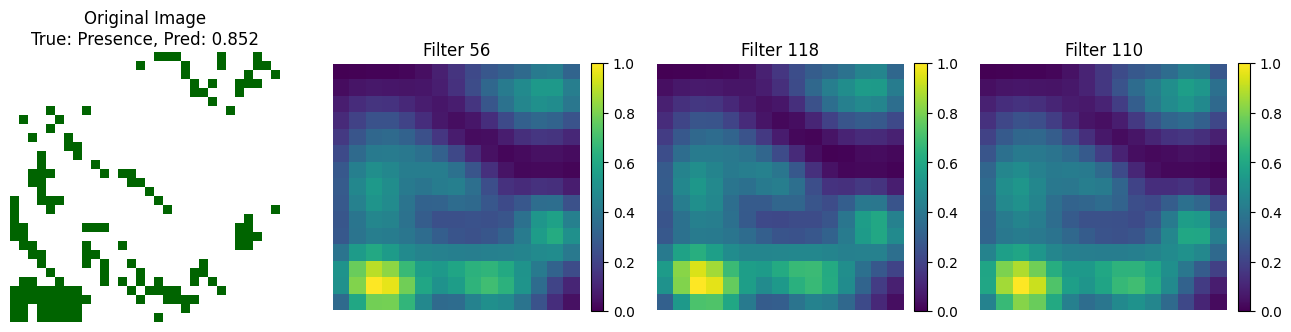

In [36]:
# @title
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap

# Custom colormap: 0 = white, 1 = dark green
cmap_img = ListedColormap(['white', 'darkgreen'])

# Map label to text
label_map = {1: "Presence", 0: "Absence"}

# Directory to save plots in Colab
save_dir = Path("/content/outputs")
save_dir.mkdir(parents=True, exist_ok=True)

for i in range(len(sample_images)):
    img_batch = sample_images[i:i+1]   # shape (1,H,W,C)
    tab_batch = sample_tables[i:i+1]   # shape (1,n_features)
    label = y_test[i]                   # true label

    # --- Get model prediction ---
    pred_prob = model.predict([img_batch, tab_batch], verbose=0)[0,0]

    # Predict feature maps
    feature_maps = feature_map_model.predict([img_batch, tab_batch], verbose=0)

    # Compute mean activation per filter
    mean_activation = feature_maps.mean(axis=(1,2))  # shape (1, n_filters)

    # Get top 3 activated filters
    top3_idx = np.argsort(mean_activation[0])[::-1][:3]

    # Plot: original + 3 feature maps
    fig, axes = plt.subplots(1, 4, figsize=(16,5))

    # Original image with predicted probability
    axes[0].imshow(img_batch[0, :, :, 0], cmap=cmap_img, vmin=0, vmax=1)
    axes[0].set_title(f"Original Image\nTrue: {label_map[label]}, Pred: {pred_prob:.3f}")
    axes[0].axis("off")

    # Feature maps
    for j, idx in enumerate(top3_idx):
        activation = feature_maps[0, :, :, idx]
        activation = (activation - activation.min()) / (activation.max() - activation.min() + 1e-8)
        im = axes[j+1].imshow(activation, cmap="viridis")
        axes[j+1].set_title(f"Filter {idx}")
        axes[j+1].axis("off")
        fig.colorbar(im, ax=axes[j+1], fraction=0.046, pad=0.04)

    # Save figure
    save_path = save_dir / f"sample_{i}_{label_map[label]}.png"
    if os.path.isfile(save_path):
      os.remove(save_path)
      plt.savefig(save_path, bbox_inches="tight")
      plt.close(fig)

print(f"Plots saved to {save_dir}")


In [22]:
len(sample_images)

15

## Part II: Permutation feature importance (can be ran independently of the rest)

### II.1 Permutation importance for CNN-ANN

Large drop in AUC after shuffling→ feature is important

Small or no drop → feature is less important

Negative drop → shuffling actually improved performance (can happen due to noise or correlations)

In [ ]:

from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import rasterio
import pyreadr

#1. Load and preprocess images
def load_images_from_folder(folder):
    tif_files = sorted(folder.glob("*.tif"))
    images = []
    image_indices = []
    for tif in tif_files:
        with rasterio.open(tif) as src:
            img = src.read()
            img = np.transpose(img, (1, 2, 0))  # (H,W,C)
            img = img.astype(np.float32)
            img = np.where(np.isnan(img), 0.0, img)  # replace NaNs
            if img.ndim == 2:
                img = np.expand_dims(img, -1)
            images.append(img)
        idx = int(tif.stem.split("_")[-1])
        image_indices.append(idx)
    return np.array(images), np.array(image_indices)

presences_path = Path("../data/cropped_landcover/presences")
absences_path = Path("../data/cropped_landcover/absences")

images_pres, indices_pres = load_images_from_folder(presences_path)
images_abs, indices_abs = load_images_from_folder(absences_path)

# Labelsadding
X = np.concatenate([images_pres, images_abs], axis=0)
y = np.concatenate([np.ones(len(images_pres)), np.zeros(len(images_abs))], axis=0)
image_indices = np.concatenate([indices_pres, indices_abs], axis=0)

# 2. Load table data
rds_path = Path("../data/Table_preds/function_3_100.rds")
result = pyreadr.read_r(rds_path)
table_df = result[None]

table_features_all = table_df[['MAP','MAT']].astype(float)
table_features = table_features_all.iloc[image_indices].reset_index(drop=True)
# normalize
#table_features = (table_features - table_features.min()) / (table_features.max() - table_features.min())
#table_features = table_features.to_numpy(dtype=np.float32)

X_train, X_temp, table_train, table_temp, y_train, y_temp = train_test_split(
    X, table_features, y,
    test_size=0.2,
    random_state=123,
    stratify=y
)

X_valid, X_test, table_valid, table_test, y_valid, y_test = train_test_split(
    X_temp, table_temp, y_temp,
    test_size=0.5,
    random_state=123,
    stratify=y_temp
)

# Normalize using TRAIN ONLY

min_vals = table_train.min(axis=0)
max_vals = table_train.max(axis=0)

table_train = (table_train - min_vals) / (max_vals - min_vals)
table_valid = (table_valid - min_vals) / (max_vals - min_vals)
table_test  = (table_test  - min_vals) / (max_vals - min_vals)

table_train = table_train.to_numpy(dtype=np.float32)
table_valid = table_valid.to_numpy(dtype=np.float32)
table_test  = table_test.to_numpy(dtype=np.float32)

#  4. Load trained model
model1_path = Path.cwd() / "../outputs/cnn_bestModel.keras"
model1 = load_model(model1_path)


#  5. Build inference model
from tensorflow import keras

model1_path = Path("../outputs/cnn_bestModel.keras")
model = keras.models.load_model(model1_path)


# 6. Permutation importance
# Shuffle the features randomly and evaluate the drop (or delta)in AUC
def permutation_importance_multimodal(
    model,
    images,
    table,
    y,
    table_feature_names,
    n_repeats=10,
    seed=123
):
    rng = np.random.default_rng(seed)

    images = images.astype(np.float32)
    table = table.astype(np.float32)
    y = y.astype(np.float32)

    # --- Baseline ---
    base_pred = model.predict([images, table], verbose=0).ravel()
    base_auc = roc_auc_score(y, base_pred)

    print(f"Baseline AUC: {base_auc:.4f}")

    importances = {}

    # --- Table features ---
    for j, fname in enumerate(table_feature_names):
        drops = []
        for _ in range(n_repeats):
            table_perm = table.copy()
            rng.shuffle(table_perm[:, j])
            pred = model.predict([images, table_perm], verbose=0).ravel()
            auc = roc_auc_score(y, pred)
            drops.append(base_auc - auc)

        importances[fname] = np.mean(drops)

    # --- Image branch (whole-image permutation) ---
    drops = []
    for _ in range(n_repeats):
        idx = rng.permutation(len(images))
        images_perm = images[idx]
        pred = model.predict([images_perm, table], verbose=0).ravel()
        auc = roc_auc_score(y, pred)
        drops.append(base_auc - auc)

    importances["Image"] = np.mean(drops)

    # --- Pretty print ---
    print("\nPermutation Importances (ΔAUC):")
    for k, v in sorted(importances.items(), key=lambda x: x[1], reverse=True):
        print(f"{k:10s}: {v:+.4f}")

    return importances, base_auc




#  7. Compute importance
table_feature_names = ["MAP", "MAT"]

importances, base_auc = permutation_importance_multimodal(
    model=model,
    images=X_test,
    table=table_test,
    y=y_test,
    table_feature_names=table_feature_names,
    n_repeats=5
)


Baseline AUC: 0.9333

Permutation Importances (ΔAUC):
Image     : +0.2125
MAP       : +0.0275
MAT       : +0.0258


#### II.2 Permutation for Mimicry ANN

In [ ]:

import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
import pyreadr

# Load table data for ANN-only
rds_path = Path("../data/Table_preds/function_3_100.rds")
result = pyreadr.read_r(rds_path)
table_df = result[None]

# Select relevant columns
feature_df = table_df[['MAP','MAT','habitat_amount_3000']].astype(float)

# Load indices for presences/absences
presences_path = Path("../data/cropped_landcover/presences")
absences_path = Path("../data/cropped_landcover/absences")

def extract_indices(folder):
    tif_files = sorted(folder.glob("*.tif"))
    indices = []
    for tif in tif_files:
        idx = int(tif.stem.split("_")[-1])
        indices.append(idx)
    return np.array(indices)

indices_pres = extract_indices(presences_path)
indices_abs = extract_indices(absences_path)

# Build label vector
y = np.concatenate([
    np.ones(len(indices_pres)),
    np.zeros(len(indices_abs))
]).astype(np.float32)

# Extract corresponding rows
feature_all = feature_df
features = feature_all.iloc[np.concatenate([indices_pres, indices_abs])]
features = features.reset_index(drop=True)

# Train/valid/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    features, y, test_size=0.2, random_state=123, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp
)


# Normalize using TRAIN ONLY

min_vals = X_train.min(axis=0)
max_vals = X_train.max(axis=0)

X_train = (X_train - min_vals) / (max_vals - min_vals)
X_valid = (X_valid - min_vals) / (max_vals - min_vals)
X_test  = (X_test  - min_vals) / (max_vals - min_vals)

# Load ANN-only modeol
model2_path = Path.cwd() / "../outputs//Mirror_ANN_HA_3000_bestModel.keras"
model2 = load_model(model2_path)

# Permutation importance for table features

def permutation_importance_model2(
    model,
    table,
    y,
    feature_names,
    n_repeats=10,
    seed=42
):
    rng = np.random.default_rng(seed)

    table = np.asarray(table, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)

    # --- Baseline ---
    base_pred = model.predict(table, verbose=0).ravel()
    base_auc = roc_auc_score(y, base_pred)
    print(f"Baseline AUC: {base_auc:.4f}")

    importances = {}

    # --- Permute each feature ---
    for j, fname in enumerate(feature_names):
        drops = []
        for _ in range(n_repeats):
            table_perm = table.copy()
            rng.shuffle(table_perm[:, j])
            pred = model.predict(table_perm, verbose=0).ravel()
            auc = roc_auc_score(y, pred)
            drops.append(base_auc - auc)

        importances[fname] = np.mean(drops)

    # --- Pretty print ---
    print("\nPermutation Feature Importances (ΔAUC):")
    for k, v in sorted(importances.items(), key=lambda x: x[1], reverse=True):
        print(f"{k:22s}: {v:+.4f}")

    return importances, base_auc

feature_names = ["MAP", "MAT", "habitat_amount_3000"]

importances, base_auc = permutation_importance_model2(
    model=model2,
    table=X_test,
    y=y_test,
    feature_names=feature_names,
    n_repeats=5
)


Baseline AUC: 0.8417

Permutation Feature Importances (ΔAUC):
habitat_amount_3000   : +0.0642
MAT                   : +0.0583
MAP                   : +0.0425


#### II.3 Permutation importance for optimised ANN

In [ ]:
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
import pyreadr

# Load table data for ANN-only
rds_path = Path("../data/Table_preds/function_3_100.rds")
result = pyreadr.read_r(rds_path)
table_df = result[None]

# Select relevant columns
feature_df = table_df[['MAP','MAT','habitat_amount_3000']].astype(float)

# Load indices for presences/absences
presences_path = Path("../data/cropped_landcover/presences")
absences_path = Path("../data/cropped_landcover/absences")

def extract_indices(folder):
    tif_files = sorted(folder.glob("*.tif"))
    indices = []
    for tif in tif_files:
        idx = int(tif.stem.split("_")[-1])
        indices.append(idx)
    return np.array(indices)

indices_pres = extract_indices(presences_path)
indices_abs = extract_indices(absences_path)

# Build label vector
y = np.concatenate([
    np.ones(len(indices_pres)),
    np.zeros(len(indices_abs))
]).astype(np.float32)

# Extract corresponding rows
feature_all = feature_df
features = feature_all.iloc[np.concatenate([indices_pres, indices_abs])]
features = features.reset_index(drop=True)

# Train/valid/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    features, y, test_size=0.2, random_state=123, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp
)


# Normalize using TRAIN ONLY

min_vals = X_train.min(axis=0)
max_vals = X_train.max(axis=0)

X_train = (X_train - min_vals) / (max_vals - min_vals)
X_valid = (X_valid - min_vals) / (max_vals - min_vals)
X_test  = (X_test  - min_vals) / (max_vals - min_vals)

# Load optimised ANN-only modeol
model3_path = Path.cwd() / "../outputs/Optimised_ANN_HA_3000_bestModel.keras"
model3 = load_model(model3_path)

# Permutation importance for table features

def permutation_importance_model3(
    model,
    table,
    y,
    feature_names,
    n_repeats=10,
    seed=123
):
    rng = np.random.default_rng(seed)

    table = np.asarray(table, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)

    # --- Baseline ---
    base_pred = model.predict(table, verbose=0).ravel()
    base_auc = roc_auc_score(y, base_pred)
    print(f"Baseline AUC: {base_auc:.4f}")

    importances = {}

    # --- Permute each feature ---
    for j, fname in enumerate(feature_names):
        drops = []
        for _ in range(n_repeats):
            table_perm = table.copy()
            rng.shuffle(table_perm[:, j])
            pred = model.predict(table_perm, verbose=0).ravel()
            auc = roc_auc_score(y, pred)
            drops.append(base_auc - auc)

        importances[fname] = np.mean(drops)

    # --- Pretty print ---
    print("\nPermutation Feature Importances (ΔAUC):")
    for k, v in sorted(importances.items(), key=lambda x: x[1], reverse=True):
        print(f"{k:22s}: {v:+.4f}")

    return importances, base_auc

feature_names = ["MAP", "MAT", "habitat_amount_3000"]

importances, base_auc = permutation_importance_model3(
    model=model3,
    table=X_test,
    y=y_test,
    feature_names=feature_names,
    n_repeats=5
)


Baseline AUC: 0.8583

Permutation Feature Importances (ΔAUC):
MAP                   : +0.1462
MAT                   : +0.0642
habitat_amount_3000   : +0.0338


#### II.4 Logistic regression model

In [ ]:
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from joblib import load
import pyreadr

# 1. Load table data
rds_path = Path("../data/Table_preds/function_3_100.rds")
result = pyreadr.read_r(rds_path)
table_df = result[None]

feature_df = table_df[['MAP', 'MAT', 'habitat_amount_3000']].astype(float)

# 2. Load presence / absence indices (ORDERED)
presences_path = Path("../data/cropped_landcover/presences")
absences_path = Path("../data/cropped_landcover/absences")

def extract_indices(folder):
    tif_files = sorted(folder.glob("*.tif"))
    return np.array([int(t.stem.split("_")[-1]) for t in tif_files])

indices_pres = extract_indices(presences_path)
indices_abs  = extract_indices(absences_path)

# 3. Labels + features
y = np.concatenate([
    np.ones(len(indices_pres)),
    np.zeros(len(indices_abs))
]).astype(np.float32)

features = feature_df.iloc[np.concatenate([indices_pres, indices_abs])]
features = features.reset_index(drop=True)

# 4. Train / valid / test split
X_train, X_temp, y_train, y_temp = train_test_split(
    features, y, test_size=0.2, random_state=123, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp
)

# 5. Normalize using TRAIN ONLY
min_vals = X_train.min(axis=0)
max_vals = X_train.max(axis=0)

X_train = ((X_train - min_vals) / (max_vals - min_vals)).to_numpy(np.float32)
X_valid = ((X_valid - min_vals) / (max_vals - min_vals)).to_numpy(np.float32)
X_test  = ((X_test  - min_vals) / (max_vals - min_vals)).to_numpy(np.float32)

# 6. Load trained logistic regression
model_path = Path.cwd() / "../outputs/LogReg_HA_3000_model.joblib"
maxent = load(model_path)

# 7. Permutation importance
def permutation_importance_logreg(
    model,
    X,
    y,
    feature_names,
    n_repeats=10,
    seed=123
):
    rng = np.random.default_rng(seed)

    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)

    # --- Baseline ---
    base_probs = model.predict_proba(X)[:, 1]
    base_auc = roc_auc_score(y, base_probs)
    print(f"Baseline AUC: {base_auc:.4f}")

    importances = {}

    # --- Permute each feature ---
    for j, fname in enumerate(feature_names):
        drops = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            rng.shuffle(X_perm[:, j])

            probs = model.predict_proba(X_perm)[:, 1]
            auc = roc_auc_score(y, probs)

            drops.append(base_auc - auc)

        importances[fname] = np.mean(drops)

    # --- Pretty print ---
    print("\nPermutation Feature Importances (ΔAUC):")
    for k, v in sorted(importances.items(), key=lambda x: x[1], reverse=True):
        print(f"{k:22s}: {v:+.4f}")

    return importances, base_auc

# --------------------------------------------------
# 8. Run importance on test set
# --------------------------------------------------
feature_names = ["MAP", "MAT", "habitat_amount_3000"]

importances, base_auc = permutation_importance_logreg(
    model=maxent,
    X=X_test,
    y=y_test,
    feature_names=feature_names,
    n_repeats=5
)


Baseline AUC: 0.8417

Permutation Feature Importances (ΔAUC):
MAT                   : +0.1317
MAP                   : +0.0942
habitat_amount_3000   : +0.0317


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist